<a href="https://colab.research.google.com/github/wphall/CO2-Equilibrium/blob/main/Handling_Data_with_Pandas_and_Matplotlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/ec/Anscombe%27s_quartet_3.svg" width="600"/>
</div>

Group I (X)	|Group I (Y)	|Group II (X)	|Group II (Y)	|Group III (X)	|Group III (Y)	|Group IV (X)	|Group IV (Y)
---|---|---|---|---|---|---|---
10.0|	8.04|	10.0|	9.14|	10.0|	7.46|	8.0|	6.58
8.0	|6.95	|8.0|	8.14|	8.0|	6.77|	8.0	|5.76
13.0|	7.58|	13.0|	8.74|	13.0|	12.74|	8.0|	7.71
9.0|	8.81|	9.0|	8.77|	9.0	|7.11|	8.0|	8.84
11.0|	8.33|	11.0|	9.26|	11.0|	7.81|	8.0|	8.47
14.0|	9.96|	14.0|	8.10|	14.0|	8.84|	8.0	|7.04
6.0|	7.24|	6.0|	6.13|	6.0	|6.08	|8.0|	5.25
4.0	|4.26|	4.0	|3.10|	4.0|	5.39|	19.0|	12.50
12.0|	10.84	|12.0|	9.13|	12.0|	8.15|	8.0|	5.56
7.0|	4.82|	7.0|	7.26|	7.0|	6.42|	8.0	|7.91
5.0|	5.68|	5.0|	4.74|	5.0|	5.73|	8.0|	6.89

[Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe's_quartet#)


In this notebook we will calculate the pH of a system of DI water at equilibrium with carbon dioxide gas with a partial pressure of 100 to 500 ppm in increments of 10 ppm.

**Activity**: Make an array ("PPMVals") to hold the values for the partial pressures, and a pandas dataframe ("dfRangeP")to hold the 7 concentrations at each partial pressure.

For the array, numpy has two similar functions for creating arrays spanning a range of values.  The first is [np.arange(start, stop, step)](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and the second is [np.linspace(start, stop, num)](https://numpy.org/doc/stable/reference/generated/numpy.arange.html).  Either works well, but they are subtley different as the stop value for "arange" is not incluse and the stop value for linspace is inclusive.  Make your array to have approximately at least 50 integer values in evenly-spaced integer increments.

For the dataframe make the indexs be pressures ("PPMVals") and make the columns be the three letter codes for each of the 7 species ["atm","co2","bct","car","hdr","hox","cal"].

In [ ]:
import numpy as np                    #the numpy library contains fast math functions designed to operate on and store arrays of numbers
import matplotlib.pyplot as plt       #the matplotlib.pyplot library is used to make plots and figures
import pandas as pd                   #the pandas library deals with named columns and rows of data called a dataframe (similar to an Excel worksheet with customizable row and column labels)
from scipy.optimize import fsolve     #the scipy library has thousands of functions, fsolve is one for searching for the roots of a system of equations
from google.colab import data_table   #this colab library supports nice display (formatting) and interaction (sorting, downloading) with tables of data including pandas dataframes
data_table.enable_dataframe_formatter()                       #turn on interactive, nice formatting of tabular data
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.3e}"  #change the default number format to be scientific notation with 3 digits after the decimal

Kh=3.40e-2            #Kh  = co2/atm      = x[1]/x[0]
Ka1=4.46e-7           #Ka1 = hdr*bct/co2  = x[4]*x[2]/x[1]
Ka2=4.69e-11          #Ka2 = hdr*car/bct  = x[4]*x[3]/x[2]
Kw=1.0e-14            #Kw  = hdr*hox      = x[4]*x[5]
#Ksp=4.6e-9           #Ksp = cal*car      = x[6]*x[3]
Ksp=0                 #this is the CO2 only case, setting this to zero will hold [calcium}=0

Colors=["Teal","DarkRed","DarkGreen","Purple","Red","Blue","DarkOrange"]
ChartColors=["DarkRed","DarkGreen","Purple","DarkOrange"]

def FunCO2OnlyOpen(x):                        #our function's input is an array called "x" while inside the function, indexing starts with zero
    f0=x[1]-(Kh*x[0])                         #Kh, Henry's Law for CO2 gas
    f1=x[4]*x[2]-(Ka1*x[1])                   #Ka1, of dissolved CO2 to bicarbonate
    f2=x[4]*x[3]-(Ka2*x[2])                   #Ka2, of bicarbonate to carbonate
    f3=x[4]*x[5]-Kw                           #Kw, dissociation of water
    f4=x[6]*x[3]-Ksp                          #Ksp, dissociation of calcium carbonate, Ksp=0 in CO2 only, makes[cal]=0
    f5=x[4]+2*x[6]-x[2]-2*x[3]-x[5]           #charge balance
    f6=x[0]-Pinit                           #partial pressure of CO2 (x[0]) is constant and always equal to the value of Pinit, unlimited total dissolved carbon
    return np.array([f0,f1,f2,f3,f4,f5,f6])   #return the signed residual of each equation

def FunCO2OnlyClosed(x):
    f0=x[1]-(Kh*x[0])
    f1=x[4]*x[2]-(Ka1*x[1])
    f2=x[4]*x[3]-(Ka2*x[2])
    f3=x[4]*x[5]-Kw
    f4=x[6]
    f5=x[4]+2*x[6]-x[2]-2*x[3]-x[5]
    f6=x[1]+x[2]+x[3]-(Kh*Pinit)            #partial pressure of CO2 (x[0]) is variable and decreases as it dissolves, limited total dissolved carbon
    return np.array([f0,f1,f2,f3,f4,f5,f6])

PPMVals=np.arange(100,510,10)
print("pressures = ",PPMVals)
print("Number of pressures = ",len(PPMVals))

PPMIdxs=np.arange(len(PPMVals))
print("Index of each pressure ",PPMIdxs)

dfRangeP=pd.DataFrame(index=PPMVals,columns=["atm","co2","bct","car","hdr","hox","cal"])
dfRangeP

pressures =  [100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270
 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450
 460 470 480 490 500]
Number of pressures =  41
Index of each pressure  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


,atm,co2,bct,car,hdr,hox,cal
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can now loop through each of the pressures in the range  In each pass we will make an initial guess, use fsolve to find the concentrations that fit the constraints, and store the results in the dataframe.  Once the dataframe is filled, we can calculate and plot the pH of the two models and compare their results

In [ ]:
for PPM,Index in zip(PPMVals,PPMIdxs):     #this loop will step through the mixing ratios and their indexes
  Pinit=PPM/1.0e6                          #change units of Pinit for this iteration of the loop to atmospheres
  print("Pressure=",PPM,end=' ')           #print the pressure to the screen, you may want to comment this later

  #inital guess for the CO2 only system loaded into an array
  atm=Pinit
  co2=Pinit*Kh
  bct=np.sqrt(Ka1*co2)
  hdr=np.sqrt(Ka1*co2)
  hox=Kw/hdr
  car=Ka2*bct/hdr
  cal=0.0
  xGuess=np.array([atm,co2,bct,car,hdr,hox,cal])

  xCalc=fsolve(FunCO2OnlyOpen,xGuess) #SciPy does the work!
  dfRangeP.iloc[Index,:]=xCalc        #store the result in the appropriate spot in the dataframe
  pHCalc=-np.log10(xCalc[4])          #hydronium ion has an index of 4 (5th value, but indexing starts with 0!)
  print("pH=",pHCalc)                 #print the calculated pH, you may want to comment this later

dfRangeP #display the dataframe

Pressure= 100 pH= 5.908149444271326
Pressure= 110 pH= 5.887583216563337
Pressure= 120 pH= 5.868797454809561
Pressure= 130 pH= 5.851508291887071
Pressure= 140 pH= 5.835494764215306
Pressure= 150 pH= 5.820581497861889
Pressure= 160 pH= 5.806626970001201
Pressure= 170 pH= 5.793515321046921
Pressure= 180 pH= 5.7811505018424665
Pressure= 190 pH= 5.769451999738014
Pressure= 200 pH= 5.7583516584983006
Pressure= 210 pH= 5.747791272401923
Pressure= 220 pH= 5.737720738820608
Pressure= 230 pH= 5.728096620594917
Pressure= 240 pH= 5.718881013731995
Pressure= 250 pH= 5.710040645784595
Pressure= 260 pH= 5.701546150707767
Pressure= 270 pH= 5.693371480304191
Pressure= 280 pH= 5.685493422498936
Pressure= 290 pH= 5.677891203990245
Pressure= 300 pH= 5.670546160138115
Pressure= 310 pH= 5.663441458885161
Pressure= 320 pH= 5.656561868430768
Pressure= 330 pH= 5.6498935605939336
Pressure= 340 pH= 5.6434239434811
Pressure= 350 pH= 5.637141518369612
Pressure= 360 pH= 5.63103575671955
Pressure= 370 pH= 5.62509699

,atm,co2,bct,car,hdr,hox,cal
100,0.0001,0.000003,0.000001,0.0,0.000001,0.0,0.0
110,0.00011,0.000004,0.000001,0.0,0.000001,0.0,-0.0
120,0.00012,0.000004,0.000001,0.0,0.000001,0.0,-0.0
130,0.00013,0.000004,0.000001,0.0,0.000001,0.0,-0.0
140,0.00014,0.000005,0.000001,0.0,0.000001,0.0,0.0
150,0.00015,0.000005,0.000002,0.0,0.000002,0.0,-0.0
160,0.00016,0.000005,0.000002,0.0,0.000002,0.0,0.0
170,0.00017,0.000006,0.000002,0.0,0.000002,0.0,-0.0
180,0.00018,0.000006,0.000002,0.0,0.000002,0.0,-0.0
190,0.00019,0.000006,0.000002,0.0,0.000002,0.0,0.0


Some links about plotting with matlab

https://matplotlib.org/stable/users/explain/quick_start.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

https://matplotlib.org/stable/api/markers_api.html

Text(0, 0.5, 'pH')

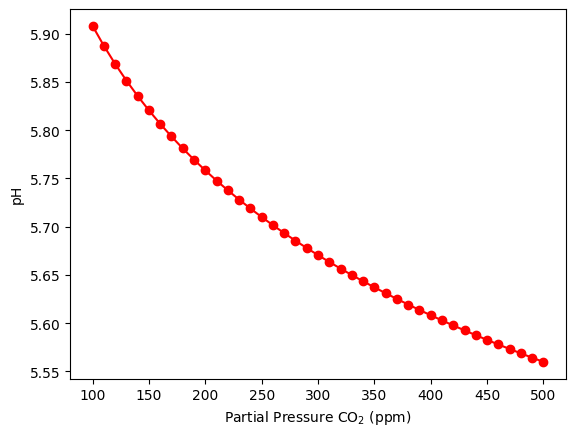

In [ ]:
press=PPMVals
hyds=np.array(dfRangeP['hdr'],dtype=float)
pHs=-np.log10(hyds)

fig,ax=plt.subplots()
ax.plot(press,pHs, linestyle='solid', marker='o', color=Colors[4])
ax.set_xlabel("Partial Pressure $\mathrm{CO_2}$ (ppm)")
ax.set_ylabel("pH")

In [ ]:
from scipy.optimize import fsolve
import numpy as np

def FunNaOH(x):
  # x[0]=hdr
  # x[1]=hox
  # x[2]=sod
  f0=x[0]*x[1]-Kw      #Kw=hdr*hox so 0=hdr*hox-Kw
  f1=x[0]+x[2]-x[1]    #charge balance
  f3=x[2]-F            #mass balance
  res=np.array([f0, f1, f3])
  return res

Kw=1e-14
F=1.5e-8

sod=F
hox=F+1.0e-7
hdr=Kw/hox
estimate=np.array([hdr,hox,sod])

print('concentrations into fsolve= ',estimate)
pHest=-np.log10(estimate[0])
print("estimated pH = "+"{:.2f}".format(pHest))
residualsEstimate=FunNaOH(estimate)
print('residuals of the estimates = ',residualsEstimate)

result=fsolve(FunNaOH,estimate)
print('concentrations out of fsolve= ',result)
residualsSolved=FunNaOH(result)
print('residuals of the solved equations = ',residualsSolved)

pHsol=-np.log10(result[0])
print("solved pH = "+"{:.2f}".format(pHsol))

concentrations into fsolve=  [8.69565217e-08 1.15000000e-07 1.50000000e-08]
estimated pH = 7.06
residuals of the estimates =  [ 0.00000000e+00 -1.30434783e-08  0.00000000e+00]
concentrations out of fsolve=  [9.27808556e-08 1.07780856e-07 1.50000000e-08]
residuals of the solved equations =  [0. 0. 0.]
solved pH = 7.03


At this point you can go back to the [$\mathrm{CO_2}$ modeling activity](https://colab.research.google.com/drive/1JmzYY-f_uMBbdWO7Q5ehC9B1xWakEKcJ?usp=sharing), or work in the code block below customizing your plot.